In [1]:
from environments import ZeroDCleanupEnv
from agents import QAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-22 01:06:46,011	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False

In [5]:
num_episodes = 200
verbose_episode = num_episodes - 1
max_steps_per_episode = 1000
state_dim = 4
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
lr = 0.01
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.9999
epsilon_min = 0.05
batch_size = 128

In [8]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = QAgent(device=device,
                                     num_action_outputs=num_agents,
                                     action_size=action_dim,
                                     state_dim=state_dim,
                                     lr=lr,
                                     gamma=gamma,
                                     epsilon=epsilon,
                                     epsilon_decay=epsilon_decay,
                                     epsilon_min=epsilon_min,
                                     batch_size=batch_size,
                                     q_layers=[
                                         (state_dim, 64),
                                         (64, 32),
                                         #(64, 64),
                                         (32, 32),
                                         (32, action_dim * num_agents)
                                     ],
                                     verbose=False)

In [9]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [10]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [11]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / num_dirt, num_picker / num_cleaner, num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        next_state = np.array([num_apples / (num_dirt + 1e-7), num_picker / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(state, actions_list, reward, next_state)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending reward: {ending_reward}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_ep_rewards.append(ending_reward)

    if ending_reward > 5000 and ending_ep_rewards[-2] > 5000 and agentCoordinator.epsilon < 0.1:
        break

    

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

/var/folders/6q/4vwdpgt97yn2bsff6ptdg6pm0000gn/T/ipykernel_60553/1773952529.py:10: RuntimeWarning: invalid value encountered in scalar divide
  state = np.array([num_apples / num_dirt, num_picker / num_cleaner, num_apples, num_dirt])


========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


 15%|█▌        | 154/1000 [00:00<00:00, 1539.04it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 784.27it/s] 


ending reward: 2541
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 813.69it/s]


ending reward: 2111
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 814.75it/s]


ending reward: 1998
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 816.61it/s]


ending reward: 1446
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 794.46it/s]


ending reward: 1692
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 804.28it/s]


ending reward: 882
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 830.63it/s]


ending reward: 680
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 830.42it/s]


ending reward: 383
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.81it/s]


ending reward: 428
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 765.79it/s]


ending reward: 300
========= End of Episode 9 =========
========= Episode 10 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.56it/s]


ending reward: 245
========= End of Episode 10 =========
========= Episode 11 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 793.26it/s]


ending reward: 270
========= End of Episode 11 =========
========= Episode 12 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.89it/s]


ending reward: 211
========= End of Episode 12 =========
========= Episode 13 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 828.57it/s]


ending reward: 186
========= End of Episode 13 =========
========= Episode 14 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 832.12it/s]


ending reward: 184
========= End of Episode 14 =========
========= Episode 15 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 792.81it/s]


ending reward: 125
========= End of Episode 15 =========
========= Episode 16 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.95it/s]


ending reward: 110
========= End of Episode 16 =========
========= Episode 17 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.77it/s]


ending reward: 77
========= End of Episode 17 =========
========= Episode 18 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.29it/s]


ending reward: 72
========= End of Episode 18 =========
========= Episode 19 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 746.01it/s]


ending reward: 69
========= End of Episode 19 =========
========= Episode 20 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 755.29it/s]


ending reward: 58
========= End of Episode 20 =========
========= Episode 21 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 757.18it/s]


ending reward: 52
========= End of Episode 21 =========
========= Episode 22 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 801.40it/s]


ending reward: 60
========= End of Episode 22 =========
========= Episode 23 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 807.26it/s]


ending reward: 30
========= End of Episode 23 =========
========= Episode 24 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 797.99it/s]


ending reward: 45
========= End of Episode 24 =========
========= Episode 25 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 774.93it/s]


ending reward: 72
========= End of Episode 25 =========
========= Episode 26 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 813.22it/s]


ending reward: 39
========= End of Episode 26 =========
========= Episode 27 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 814.81it/s]


ending reward: 40
========= End of Episode 27 =========
========= Episode 28 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.73it/s]


ending reward: 67
========= End of Episode 28 =========
========= Episode 29 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 789.67it/s]


ending reward: 38
========= End of Episode 29 =========
========= Episode 30 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.43it/s]


ending reward: 46
========= End of Episode 30 =========
========= Episode 31 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.43it/s]


ending reward: 36
========= End of Episode 31 =========
========= Episode 32 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.27it/s]


ending reward: 53
========= End of Episode 32 =========
========= Episode 33 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 788.19it/s]


ending reward: 31
========= End of Episode 33 =========
========= Episode 34 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 798.93it/s]


ending reward: 37
========= End of Episode 34 =========
========= Episode 35 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 830.00it/s]


ending reward: 56
========= End of Episode 35 =========
========= Episode 36 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 828.63it/s]


ending reward: 68
========= End of Episode 36 =========
========= Episode 37 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.80it/s]


ending reward: 28
========= End of Episode 37 =========
========= Episode 38 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 830.57it/s]


ending reward: 70
========= End of Episode 38 =========
========= Episode 39 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.41it/s]


ending reward: 19
========= End of Episode 39 =========
========= Episode 40 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 799.64it/s]


ending reward: 60
========= End of Episode 40 =========
========= Episode 41 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.24it/s]


ending reward: 50
========= End of Episode 41 =========
========= Episode 42 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 831.73it/s]


ending reward: 47
========= End of Episode 42 =========
========= Episode 43 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 833.19it/s]


ending reward: 30
========= End of Episode 43 =========
========= Episode 44 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.23it/s]


ending reward: 23
========= End of Episode 44 =========
========= Episode 45 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 802.30it/s]


ending reward: 54
========= End of Episode 45 =========
========= Episode 46 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.05it/s]


ending reward: 63
========= End of Episode 46 =========
========= Episode 47 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.26it/s]


ending reward: 27
========= End of Episode 47 =========
========= Episode 48 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 741.17it/s]


ending reward: 44
========= End of Episode 48 =========
========= Episode 49 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.35it/s]


ending reward: 35
========= End of Episode 49 =========
========= Episode 50 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 831.21it/s]


ending reward: 44
========= End of Episode 50 =========
========= Episode 51 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 796.40it/s]


ending reward: 30
========= End of Episode 51 =========
========= Episode 52 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 783.46it/s]


ending reward: 29
========= End of Episode 52 =========
========= Episode 53 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.88it/s]


ending reward: 57
========= End of Episode 53 =========
========= Episode 54 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 802.00it/s]


ending reward: 51
========= End of Episode 54 =========
========= Episode 55 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.25it/s]


ending reward: 65
========= End of Episode 55 =========
========= Episode 56 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 788.81it/s]


ending reward: 29
========= End of Episode 56 =========
========= Episode 57 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.58it/s]


ending reward: 37
========= End of Episode 57 =========
========= Episode 58 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 735.90it/s]


ending reward: 53
========= End of Episode 58 =========
========= Episode 59 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.71it/s]


ending reward: 38
========= End of Episode 59 =========
========= Episode 60 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.28it/s]


ending reward: 50
========= End of Episode 60 =========
========= Episode 61 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 798.10it/s]


ending reward: 43
========= End of Episode 61 =========
========= Episode 62 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.11it/s]


ending reward: 65
========= End of Episode 62 =========
========= Episode 63 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.16it/s]


ending reward: 42
========= End of Episode 63 =========
========= Episode 64 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 828.97it/s]


ending reward: 54
========= End of Episode 64 =========
========= Episode 65 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.95it/s]


ending reward: 51
========= End of Episode 65 =========
========= Episode 66 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 804.46it/s]


ending reward: 44
========= End of Episode 66 =========
========= Episode 67 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 768.21it/s]


ending reward: 40
========= End of Episode 67 =========
========= Episode 68 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.35it/s]


ending reward: 68
========= End of Episode 68 =========
========= Episode 69 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.06it/s]


ending reward: 32
========= End of Episode 69 =========
========= Episode 70 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 828.52it/s]


ending reward: 27
========= End of Episode 70 =========
========= Episode 71 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.08it/s]


ending reward: 56
========= End of Episode 71 =========
========= Episode 72 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 763.05it/s]


ending reward: 51
========= End of Episode 72 =========
========= Episode 73 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.70it/s]


ending reward: 50
========= End of Episode 73 =========
========= Episode 74 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 828.46it/s]


ending reward: 53
========= End of Episode 74 =========
========= Episode 75 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.87it/s]


ending reward: 67
========= End of Episode 75 =========
========= Episode 76 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.78it/s]


ending reward: 49
========= End of Episode 76 =========
========= Episode 77 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 750.89it/s]


ending reward: 57
========= End of Episode 77 =========
========= Episode 78 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.70it/s]


ending reward: 49
========= End of Episode 78 =========
========= Episode 79 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.56it/s]


ending reward: 69
========= End of Episode 79 =========
========= Episode 80 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.17it/s]


ending reward: 55
========= End of Episode 80 =========
========= Episode 81 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.80it/s]


ending reward: 22
========= End of Episode 81 =========
========= Episode 82 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 762.72it/s]


ending reward: 36
========= End of Episode 82 =========
========= Episode 83 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.25it/s]


ending reward: 33
========= End of Episode 83 =========
========= Episode 84 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.07it/s]


ending reward: 41
========= End of Episode 84 =========
========= Episode 85 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.03it/s]


ending reward: 23
========= End of Episode 85 =========
========= Episode 86 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.59it/s]


ending reward: 23
========= End of Episode 86 =========
========= Episode 87 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.32it/s]


ending reward: 75
========= End of Episode 87 =========
========= Episode 88 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 795.55it/s]


ending reward: 60
========= End of Episode 88 =========
========= Episode 89 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.56it/s]


ending reward: 53
========= End of Episode 89 =========
========= Episode 90 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.15it/s]


ending reward: 39
========= End of Episode 90 =========
========= Episode 91 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.98it/s]


ending reward: 22
========= End of Episode 91 =========
========= Episode 92 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.39it/s]


ending reward: 95
========= End of Episode 92 =========
========= Episode 93 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 747.66it/s]


ending reward: 52
========= End of Episode 93 =========
========= Episode 94 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.75it/s]


ending reward: 44
========= End of Episode 94 =========
========= Episode 95 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 829.66it/s]


ending reward: 35
========= End of Episode 95 =========
========= Episode 96 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 782.87it/s]


ending reward: 29
========= End of Episode 96 =========
========= Episode 97 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 711.46it/s]


ending reward: 26
========= End of Episode 97 =========
========= Episode 98 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 785.22it/s]


ending reward: 62
========= End of Episode 98 =========
========= Episode 99 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 826.55it/s]


ending reward: 31
========= End of Episode 99 =========
========= Episode 100 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.05it/s]


ending reward: 34
========= End of Episode 100 =========
========= Episode 101 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.83it/s]


ending reward: 50
========= End of Episode 101 =========
========= Episode 102 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 713.81it/s]


ending reward: 33
========= End of Episode 102 =========
========= Episode 103 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 775.62it/s]


ending reward: 46
========= End of Episode 103 =========
========= Episode 104 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 477.38it/s]


ending reward: 21
========= End of Episode 104 =========
========= Episode 105 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 764.57it/s]


ending reward: 28
========= End of Episode 105 =========
========= Episode 106 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 774.91it/s]


ending reward: 35
========= End of Episode 106 =========
========= Episode 107 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 773.80it/s]


ending reward: 76
========= End of Episode 107 =========
========= Episode 108 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 817.11it/s]


ending reward: 55
========= End of Episode 108 =========
========= Episode 109 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 817.37it/s]


ending reward: 21
========= End of Episode 109 =========
========= Episode 110 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.56it/s]


ending reward: 38
========= End of Episode 110 =========
========= Episode 111 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 827.03it/s]


ending reward: 38
========= End of Episode 111 =========
========= Episode 112 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 792.41it/s]


ending reward: 41
========= End of Episode 112 =========
========= Episode 113 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 771.14it/s]


ending reward: 43
========= End of Episode 113 =========
========= Episode 114 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 830.66it/s]


ending reward: 37
========= End of Episode 114 =========
========= Episode 115 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.52it/s]


ending reward: 20
========= End of Episode 115 =========
========= Episode 116 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.23it/s]


ending reward: 35
========= End of Episode 116 =========
========= Episode 117 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 791.89it/s]


ending reward: 55
========= End of Episode 117 =========
========= Episode 118 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.73it/s]


ending reward: 18
========= End of Episode 118 =========
========= Episode 119 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 813.61it/s]


ending reward: 41
========= End of Episode 119 =========
========= Episode 120 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 799.79it/s]


ending reward: 30
========= End of Episode 120 =========
========= Episode 121 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.59it/s]


ending reward: 66
========= End of Episode 121 =========
========= Episode 122 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 793.93it/s]


ending reward: 85
========= End of Episode 122 =========
========= Episode 123 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.12it/s]


ending reward: 29
========= End of Episode 123 =========
========= Episode 124 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.75it/s]


ending reward: 36
========= End of Episode 124 =========
========= Episode 125 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 712.78it/s]


ending reward: 23
========= End of Episode 125 =========
========= Episode 126 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 414.55it/s]


ending reward: 76
========= End of Episode 126 =========
========= Episode 127 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:02<00:00, 461.28it/s]


ending reward: 41
========= End of Episode 127 =========
========= Episode 128 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 778.93it/s]


ending reward: 41
========= End of Episode 128 =========
========= Episode 129 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.40it/s]


ending reward: 44
========= End of Episode 129 =========
========= Episode 130 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 748.94it/s]


ending reward: 30
========= End of Episode 130 =========
========= Episode 131 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 791.62it/s]


ending reward: 38
========= End of Episode 131 =========
========= Episode 132 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 777.99it/s]


ending reward: 44
========= End of Episode 132 =========
========= Episode 133 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.83it/s]


ending reward: 50
========= End of Episode 133 =========
========= Episode 134 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.02it/s]


ending reward: 18
========= End of Episode 134 =========
========= Episode 135 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.49it/s]


ending reward: 43
========= End of Episode 135 =========
========= Episode 136 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.04it/s]


ending reward: 51
========= End of Episode 136 =========
========= Episode 137 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 796.55it/s]


ending reward: 59
========= End of Episode 137 =========
========= Episode 138 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.11it/s]


ending reward: 72
========= End of Episode 138 =========
========= Episode 139 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.90it/s]


ending reward: 68
========= End of Episode 139 =========
========= Episode 140 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 800.01it/s]


ending reward: 40
========= End of Episode 140 =========
========= Episode 141 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.68it/s]


ending reward: 43
========= End of Episode 141 =========
========= Episode 142 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 768.87it/s]


ending reward: 57
========= End of Episode 142 =========
========= Episode 143 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.06it/s]


ending reward: 65
========= End of Episode 143 =========
========= Episode 144 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.50it/s]


ending reward: 27
========= End of Episode 144 =========
========= Episode 145 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 817.61it/s]


ending reward: 19
========= End of Episode 145 =========
========= Episode 146 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.93it/s]


ending reward: 61
========= End of Episode 146 =========
========= Episode 147 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 789.27it/s]


ending reward: 56
========= End of Episode 147 =========
========= Episode 148 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.12it/s]


ending reward: 94
========= End of Episode 148 =========
========= Episode 149 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 788.39it/s]


ending reward: 51
========= End of Episode 149 =========
========= Episode 150 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 810.38it/s]


ending reward: 26
========= End of Episode 150 =========
========= Episode 151 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.92it/s]


ending reward: 28
========= End of Episode 151 =========
========= Episode 152 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 756.04it/s]


ending reward: 57
========= End of Episode 152 =========
========= Episode 153 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 787.86it/s]


ending reward: 18
========= End of Episode 153 =========
========= Episode 154 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 817.54it/s]


ending reward: 73
========= End of Episode 154 =========
========= Episode 155 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.70it/s]


ending reward: 21
========= End of Episode 155 =========
========= Episode 156 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 805.13it/s]


ending reward: 47
========= End of Episode 156 =========
========= Episode 157 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 756.68it/s]


ending reward: 40
========= End of Episode 157 =========
========= Episode 158 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.48it/s]


ending reward: 30
========= End of Episode 158 =========
========= Episode 159 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.69it/s]


ending reward: 28
========= End of Episode 159 =========
========= Episode 160 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.78it/s]


ending reward: 63
========= End of Episode 160 =========
========= Episode 161 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.76it/s]


ending reward: 46
========= End of Episode 161 =========
========= Episode 162 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 791.92it/s]


ending reward: 44
========= End of Episode 162 =========
========= Episode 163 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.71it/s]


ending reward: 50
========= End of Episode 163 =========
========= Episode 164 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.99it/s]


ending reward: 33
========= End of Episode 164 =========
========= Episode 165 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 815.18it/s]


ending reward: 22
========= End of Episode 165 =========
========= Episode 166 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 816.22it/s]


ending reward: 25
========= End of Episode 166 =========
========= Episode 167 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 796.29it/s]


ending reward: 46
========= End of Episode 167 =========
========= Episode 168 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 821.42it/s]


ending reward: 79
========= End of Episode 168 =========
========= Episode 169 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 825.50it/s]


ending reward: 57
========= End of Episode 169 =========
========= Episode 170 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.95it/s]


ending reward: 54
========= End of Episode 170 =========
========= Episode 171 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.74it/s]


ending reward: 45
========= End of Episode 171 =========
========= Episode 172 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 794.72it/s]


ending reward: 43
========= End of Episode 172 =========
========= Episode 173 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 790.62it/s]


ending reward: 37
========= End of Episode 173 =========
========= Episode 174 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 816.12it/s]


ending reward: 22
========= End of Episode 174 =========
========= Episode 175 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 818.65it/s]


ending reward: 54
========= End of Episode 175 =========
========= Episode 176 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.02it/s]


ending reward: 40
========= End of Episode 176 =========
========= Episode 177 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 779.45it/s]


ending reward: 33
========= End of Episode 177 =========
========= Episode 178 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.94it/s]


ending reward: 27
========= End of Episode 178 =========
========= Episode 179 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.52it/s]


ending reward: 44
========= End of Episode 179 =========
========= Episode 180 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.62it/s]


ending reward: 38
========= End of Episode 180 =========
========= Episode 181 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.03it/s]


ending reward: 25
========= End of Episode 181 =========
========= Episode 182 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 790.24it/s]


ending reward: 44
========= End of Episode 182 =========
========= Episode 183 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 814.92it/s]


ending reward: 30
========= End of Episode 183 =========
========= Episode 184 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.16it/s]


ending reward: 17
========= End of Episode 184 =========
========= Episode 185 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.85it/s]


ending reward: 48
========= End of Episode 185 =========
========= Episode 186 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 824.52it/s]


ending reward: 61
========= End of Episode 186 =========
========= Episode 187 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 749.80it/s]


ending reward: 51
========= End of Episode 187 =========
========= Episode 188 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 807.37it/s]


ending reward: 58
========= End of Episode 188 =========
========= Episode 189 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 813.24it/s]


ending reward: 37
========= End of Episode 189 =========
========= Episode 190 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 822.57it/s]


ending reward: 56
========= End of Episode 190 =========
========= Episode 191 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 744.28it/s]


ending reward: 27
========= End of Episode 191 =========
========= Episode 192 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 789.18it/s]


ending reward: 62
========= End of Episode 192 =========
========= Episode 193 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 816.73it/s]


ending reward: 34
========= End of Episode 193 =========
========= Episode 194 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 819.75it/s]


ending reward: 37
========= End of Episode 194 =========
========= Episode 195 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 755.77it/s]


ending reward: 31
========= End of Episode 195 =========
========= Episode 196 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.38it/s]


ending reward: 42
========= End of Episode 196 =========
========= Episode 197 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 781.89it/s]


ending reward: 33
========= End of Episode 197 =========
========= Episode 198 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 823.19it/s]


ending reward: 50
========= End of Episode 198 =========
========= Episode 199 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:01<00:00, 820.83it/s]

ending reward: 42
========= End of Episode 199 =========


In [12]:
test_stats = []
num_test_episodes = 15
print("========= Testing =========")
f.write("========= Testing =========\n")

for episode in range(num_test_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / num_dirt, num_picker / num_cleaner, num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        next_state = np.array([num_apples / (num_dirt + 1e-7), num_picker / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Test =========")

    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Test =========\n")

    test_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = test_reward

    print(test_reward)

/var/folders/6q/4vwdpgt97yn2bsff6ptdg6pm0000gn/T/ipykernel_60553/2526068467.py:25: RuntimeWarning: invalid value encountered in scalar divide
  state = np.array([num_apples / num_dirt, num_picker / num_cleaner, num_apples, num_dirt])


========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5238.13it/s]


ending info: {'total_apple_consumed': 42, 'step_apple_consumed': 0, 'apple': 2, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 1, '6': 3, '0': 6, '7': 9, '4': 2, '5': 6, '9': 4, '8': 3, '2': 4, '1': 4}}
========= End of Test =========
42
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5361.78it/s]


ending info: {'total_apple_consumed': 52, 'step_apple_consumed': 0, 'apple': 1, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 7, '6': 1, '0': 6, '7': 5, '4': 7, '5': 6, '9': 5, '8': 4, '2': 5, '1': 6}}
========= End of Test =========
52
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5426.55it/s]


ending info: {'total_apple_consumed': 42, 'step_apple_consumed': 0, 'apple': 1, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 1, '6': 3, '0': 4, '7': 6, '4': 1, '5': 7, '9': 6, '8': 6, '2': 4, '1': 4}}
========= End of Test =========
42
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4924.99it/s]


ending info: {'total_apple_consumed': 45, 'step_apple_consumed': 0, 'apple': 3, 'dirt': 59, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 5, '6': 3, '0': 2, '7': 7, '4': 8, '5': 4, '9': 6, '8': 5, '2': 2, '1': 3}}
========= End of Test =========
45
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5421.00it/s]


ending info: {'total_apple_consumed': 31, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 2, '6': 1, '0': 3, '7': 1, '4': 2, '5': 2, '9': 4, '8': 5, '2': 6, '1': 5}}
========= End of Test =========
31
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5344.27it/s]


ending info: {'total_apple_consumed': 39, 'step_apple_consumed': 0, 'apple': 1, 'dirt': 58, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 7, '6': 6, '0': 4, '7': 5, '4': 3, '5': 4, '9': 2, '8': 3, '2': 4, '1': 1}}
========= End of Test =========
39
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5361.19it/s]


ending info: {'total_apple_consumed': 46, 'step_apple_consumed': 0, 'apple': 2, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 4, '6': 3, '0': 6, '7': 5, '4': 3, '5': 5, '9': 4, '8': 5, '2': 2, '1': 9}}
========= End of Test =========
46
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3936.42it/s]


ending info: {'total_apple_consumed': 29, 'step_apple_consumed': 0, 'apple': 1, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 5, '6': 4, '0': 2, '7': 5, '4': 1, '5': 6, '9': 3, '8': 1, '2': 2, '1': 0}}
========= End of Test =========
29
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 3843.40it/s]


ending info: {'total_apple_consumed': 66, 'step_apple_consumed': 0, 'apple': 5, 'dirt': 59, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 8, '6': 5, '0': 11, '7': 7, '4': 5, '5': 4, '9': 4, '8': 6, '2': 8, '1': 8}}
========= End of Test =========
66
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5257.34it/s]


ending info: {'total_apple_consumed': 38, 'step_apple_consumed': 0, 'apple': 1, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 3, '6': 4, '0': 6, '7': 5, '4': 3, '5': 1, '9': 4, '8': 3, '2': 2, '1': 7}}
========= End of Test =========
38
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5433.30it/s]


ending info: {'total_apple_consumed': 64, 'step_apple_consumed': 0, 'apple': 6, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 8, '6': 8, '0': 6, '7': 12, '4': 2, '5': 4, '9': 6, '8': 10, '2': 4, '1': 4}}
========= End of Test =========
64
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5416.19it/s]


ending info: {'total_apple_consumed': 57, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 7, '6': 4, '0': 5, '7': 2, '4': 6, '5': 6, '9': 10, '8': 5, '2': 5, '1': 7}}
========= End of Test =========
57
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 5011.37it/s]


ending info: {'total_apple_consumed': 58, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 7, '6': 6, '0': 2, '7': 9, '4': 4, '5': 6, '9': 6, '8': 8, '2': 5, '1': 5}}
========= End of Test =========
58
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4598.83it/s]


ending info: {'total_apple_consumed': 30, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 6, '6': 1, '0': 2, '7': 5, '4': 4, '5': 2, '9': 3, '8': 3, '2': 1, '1': 3}}
========= End of Test =========
30
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0, 'total_reward_by_agent': {'3': 0, '6': 0, '0': 0, '7': 0, '4': 0, '5': 0, '9': 0, '8': 0, '2': 0, '1': 0}}


100%|█████████▉| 999/1000 [00:00<00:00, 4441.60it/s]

ending info: {'total_apple_consumed': 47, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 60, 'picker': 10, 'cleaner': 0, 'total_reward_by_agent': {'3': 6, '6': 5, '0': 7, '7': 2, '4': 3, '5': 4, '9': 6, '8': 4, '2': 3, '1': 7}}
========= End of Test =========
47


In [13]:
import matplotlib.pyplot as plt

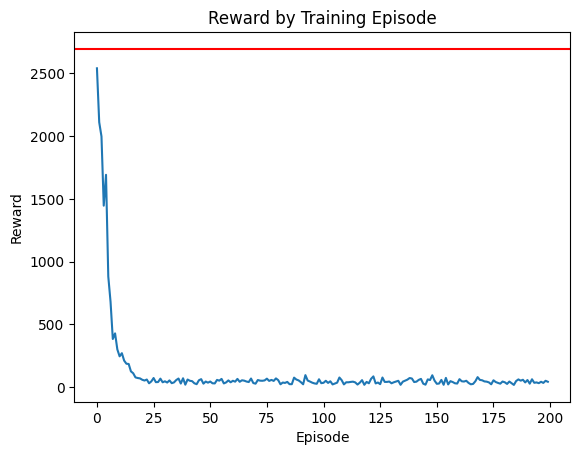

In [14]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

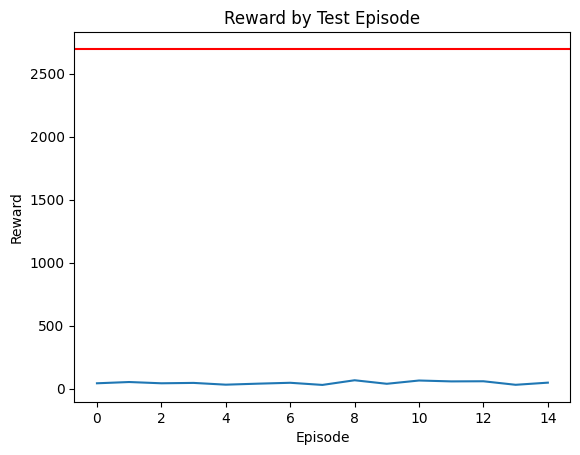

In [15]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.axhline(y=2695.57, color='r', linestyle='-')
plt.show()

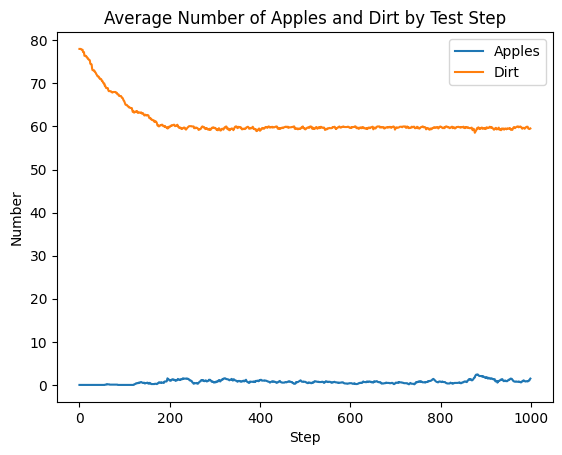

In [16]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(max_steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

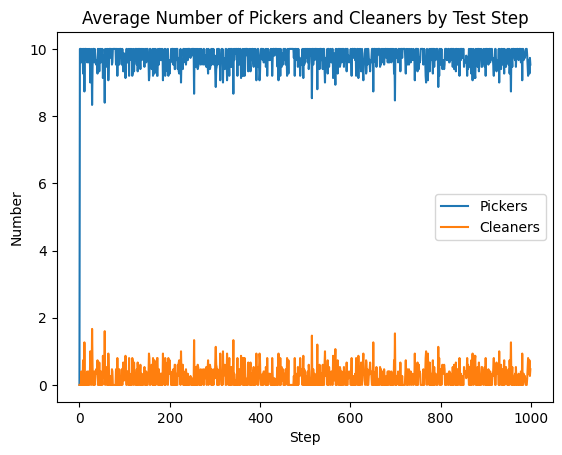

In [17]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(max_steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

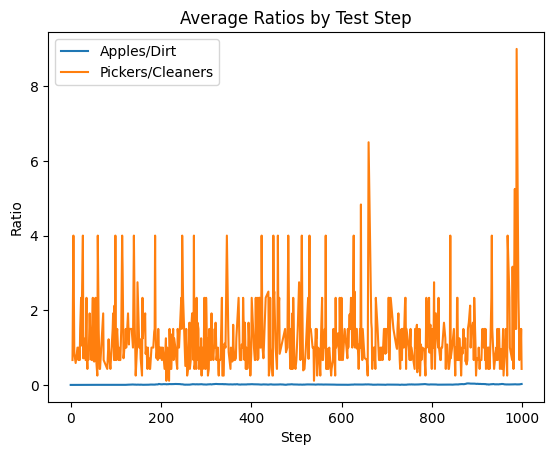

In [18]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(max_steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps, avg_apple_dirt_ratios, label="Apples/Dirt")
plt.plot(picker_cleaner_steps, avg_picker_cleaner_ratios, label="Pickers/Cleaners")
plt.legend()
plt.show()